# EDA Analysis of Raw NBA DATA

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')


## Data
 - games_details.csv .. (each-game player stats for everyone on the roster)
 - games.csv .......... (each-game team stats: final scores, points scored, field-goal & free-throw percentages, etc...)
 - players.csv ........ (index of players' names and teams)
 - ranking.csv ........ (incremental daily record of standings, games played, won, lost, win%, home record, road record)
 - teams.csv .......... (index of team info such as city and arena names and also head coach) 
 
 NOTES 
 - games and ranking will need to be linked by SEASON->SEASON_ID, GAME_DATE_EST->STANDINGSDATE(-1 day), HOME_TEAM_ID->TEAM_ID / VISITOR_TEAM_ID->TEAM_ID
 - games and game_details will need to be linked by GAME_ID->GAME_ID, HOME_TEAM_ID->TEAM_ID / VISITOR_TEAM_ID->TEAM_ID
 - just very basic stats are provided, but the data is there to generate much more, particulary running averages and other agreggates
 - some games during COVID were played in the "Bubble" - not true home arenas. These will need to be flagged at the least.
 - postseason(and possibly preseason) games will need to be flagged (by date?)
 - 99 games from early 2003 are missing data
 - redundant fields in games.csv: HOME_TEAM_ID / TEAM_ID_home and VISITOR_TEAM_ID / TEAM_ID_away
 

### games.csv

In [2]:
games = pd.read_csv(DATAPATH / "games.csv")
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,0.333,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,0.324,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,33.0,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,32.0,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25796 entries, 0 to 25795
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     25796 non-null  object 
 1   GAME_ID           25796 non-null  int64  
 2   GAME_STATUS_TEXT  25796 non-null  object 
 3   HOME_TEAM_ID      25796 non-null  int64  
 4   VISITOR_TEAM_ID   25796 non-null  int64  
 5   SEASON            25796 non-null  int64  
 6   TEAM_ID_home      25796 non-null  int64  
 7   PTS_home          25697 non-null  float64
 8   FG_PCT_home       25697 non-null  float64
 9   FT_PCT_home       25697 non-null  float64
 10  FG3_PCT_home      25697 non-null  float64
 11  AST_home          25697 non-null  float64
 12  REB_home          25697 non-null  float64
 13  TEAM_ID_away      25796 non-null  int64  
 14  PTS_away          25697 non-null  float64
 15  FG_PCT_away       25697 non-null  float64
 16  FT_PCT_away       25697 non-null  float6

In [4]:
# duplicates
games.duplicated().sum()

0

In [5]:
#null values
games.isnull().sum()

GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away         99
FG3_PCT_away        99
AST_away            99
REB_away            99
HOME_TEAM_WINS       0
dtype: int64

In [6]:
#show the nulls
games[games.isna().any(axis=1)]

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
18320,2003-10-24,10300116,Final,1610612753,1610612762,2003,1610612753,NaN,NaN,NaN,NaN,NaN,NaN,1610612762,NaN,NaN,NaN,NaN,NaN,NaN,0
18321,2003-10-24,10300108,Final,1610612737,1610612764,2003,1610612737,NaN,NaN,NaN,NaN,NaN,NaN,1610612764,NaN,NaN,NaN,NaN,NaN,NaN,0
18322,2003-10-24,10300109,Final,1610612738,1610612751,2003,1610612738,NaN,NaN,NaN,NaN,NaN,NaN,1610612751,NaN,NaN,NaN,NaN,NaN,NaN,0
18323,2003-10-24,10300113,Final,1610612759,1610612745,2003,1610612759,NaN,NaN,NaN,NaN,NaN,NaN,1610612745,NaN,NaN,NaN,NaN,NaN,NaN,0
18324,2003-10-24,10300112,Final,1610612749,1610612765,2003,1610612749,NaN,NaN,NaN,NaN,NaN,NaN,1610612765,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18414,2003-10-09,10300019,Final,1610612743,1610612756,2003,1610612743,NaN,NaN,NaN,NaN,NaN,NaN,1610612756,NaN,NaN,NaN,NaN,NaN,NaN,0
18415,2003-10-09,10300022,Final,1610612757,1610612758,2003,1610612757,NaN,NaN,NaN,NaN,NaN,NaN,1610612758,NaN,NaN,NaN,NaN,NaN,NaN,0
18416,2003-10-08,10300013,Final,1610612759,1610612763,2003,1610612759,NaN,NaN,NaN,NaN,NaN,NaN,1610612763,NaN,NaN,NaN,NaN,NaN,NaN,0
18423,2003-10-08,10300015,Final,1610612747,1610612744,2003,1610612747,NaN,NaN,NaN,NaN,NaN,NaN,1610612744,NaN,NaN,NaN,NaN,NaN,NaN,0


NOTE - 99 games from the early part of 2003 season missing data. Delete rows or manually add data?

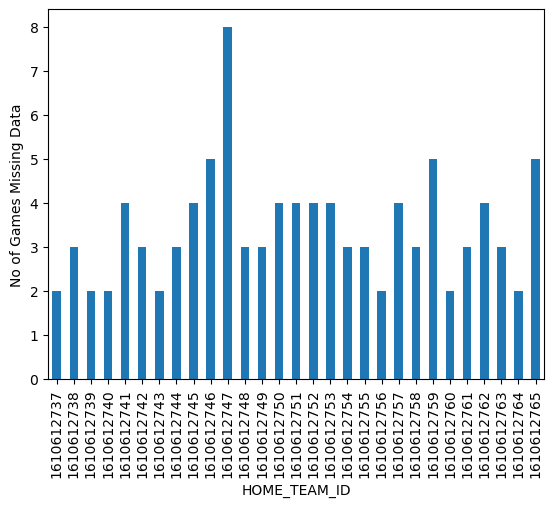

In [7]:
# check distribution of missing games 
df = games[games.isna().any(axis=1)].groupby(['HOME_TEAM_ID'])['HOME_TEAM_ID'].count()
ax = df.plot.bar(x='HOME_TEAM_ID', y='count', rot=90, ylabel="No of Games Missing Data")

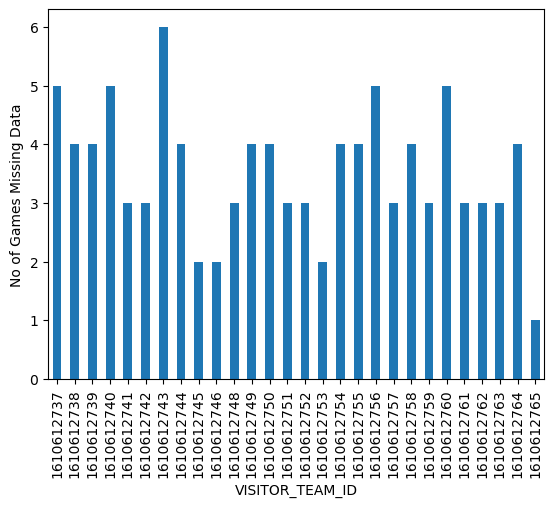

In [8]:
# check distribution of missing games 
df = games[games.isna().any(axis=1)].groupby(['VISITOR_TEAM_ID'])['VISITOR_TEAM_ID'].count()
ax = df.plot.bar(x='VISITOR_TEAM_ID', y='count', rot=90, ylabel="No of Games Missing Data")

In [9]:
#count all games not Final

games[games['GAME_STATUS_TEXT'] != 'Final'].shape[0]

0

NOTE - All games in dataset are Final. This field is not needed for modeling.

In [10]:
#check if fields are redundant

games[games['HOME_TEAM_ID'] != games['TEAM_ID_home']].shape[0]

0

In [11]:
#check if fields are redundant

games[games['VISITOR_TEAM_ID'] != games['TEAM_ID_away']].shape[0]

0

NOTE - for some reason Home and Visitor teams IDs are included twice, but are always the same

In [12]:
#fields not needed for processing, analysis, or modeling

drop_fields = ['GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away']

games = games.drop(drop_fields,axis=1)

In [13]:
# fix data types

games['GAME_DATE_EST'] = games['GAME_DATE_EST'].astype('datetime64[ns]')

category_fields = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

for cat in category_fields:
    games[cat] = games[cat].astype('category')

In [14]:
games.describe(include = 'category').T

,count,unique,top,freq
HOME_TEAM_ID,25796,30,1610612747,945
VISITOR_TEAM_ID,25796,30,1610612748,908
SEASON,25796,19,2005,1432


In [15]:
games.describe().T.applymap('{:,.4f}'.format)

,count,mean,std,min,25%,50%,75%,max
GAME_ID,"25,796.0000","21,692,079.3182","5,496,041.0508","10,300,001.0000","20,601,091.7500","21,200,400.5000","21,700,700.2500","52,000,211.0000"
PTS_home,"25,697.0000",103.1060,13.1747,36.0000,94.0000,103.0000,112.0000,168.0000
FG_PCT_home,"25,697.0000",0.4603,0.0566,0.2500,0.4210,0.4590,0.5000,0.6840
FT_PCT_home,"25,697.0000",0.7597,0.1007,0.1430,0.6960,0.7650,0.8290,1.0000
FG3_PCT_home,"25,697.0000",0.3559,0.1119,0.0000,0.2860,0.3550,0.4290,1.0000
AST_home,"25,697.0000",22.7368,5.1776,6.0000,19.0000,23.0000,26.0000,50.0000
REB_home,"25,697.0000",43.3458,6.6218,15.0000,39.0000,43.0000,48.0000,72.0000
PTS_away,"25,697.0000",100.2941,13.3430,33.0000,91.0000,100.0000,109.0000,168.0000
FG_PCT_away,"25,697.0000",0.4493,0.0555,0.2440,0.4120,0.4480,0.4870,0.6870
FT_PCT_away,"25,697.0000",0.7581,0.1034,0.1430,0.6920,0.7650,0.8330,1.0000


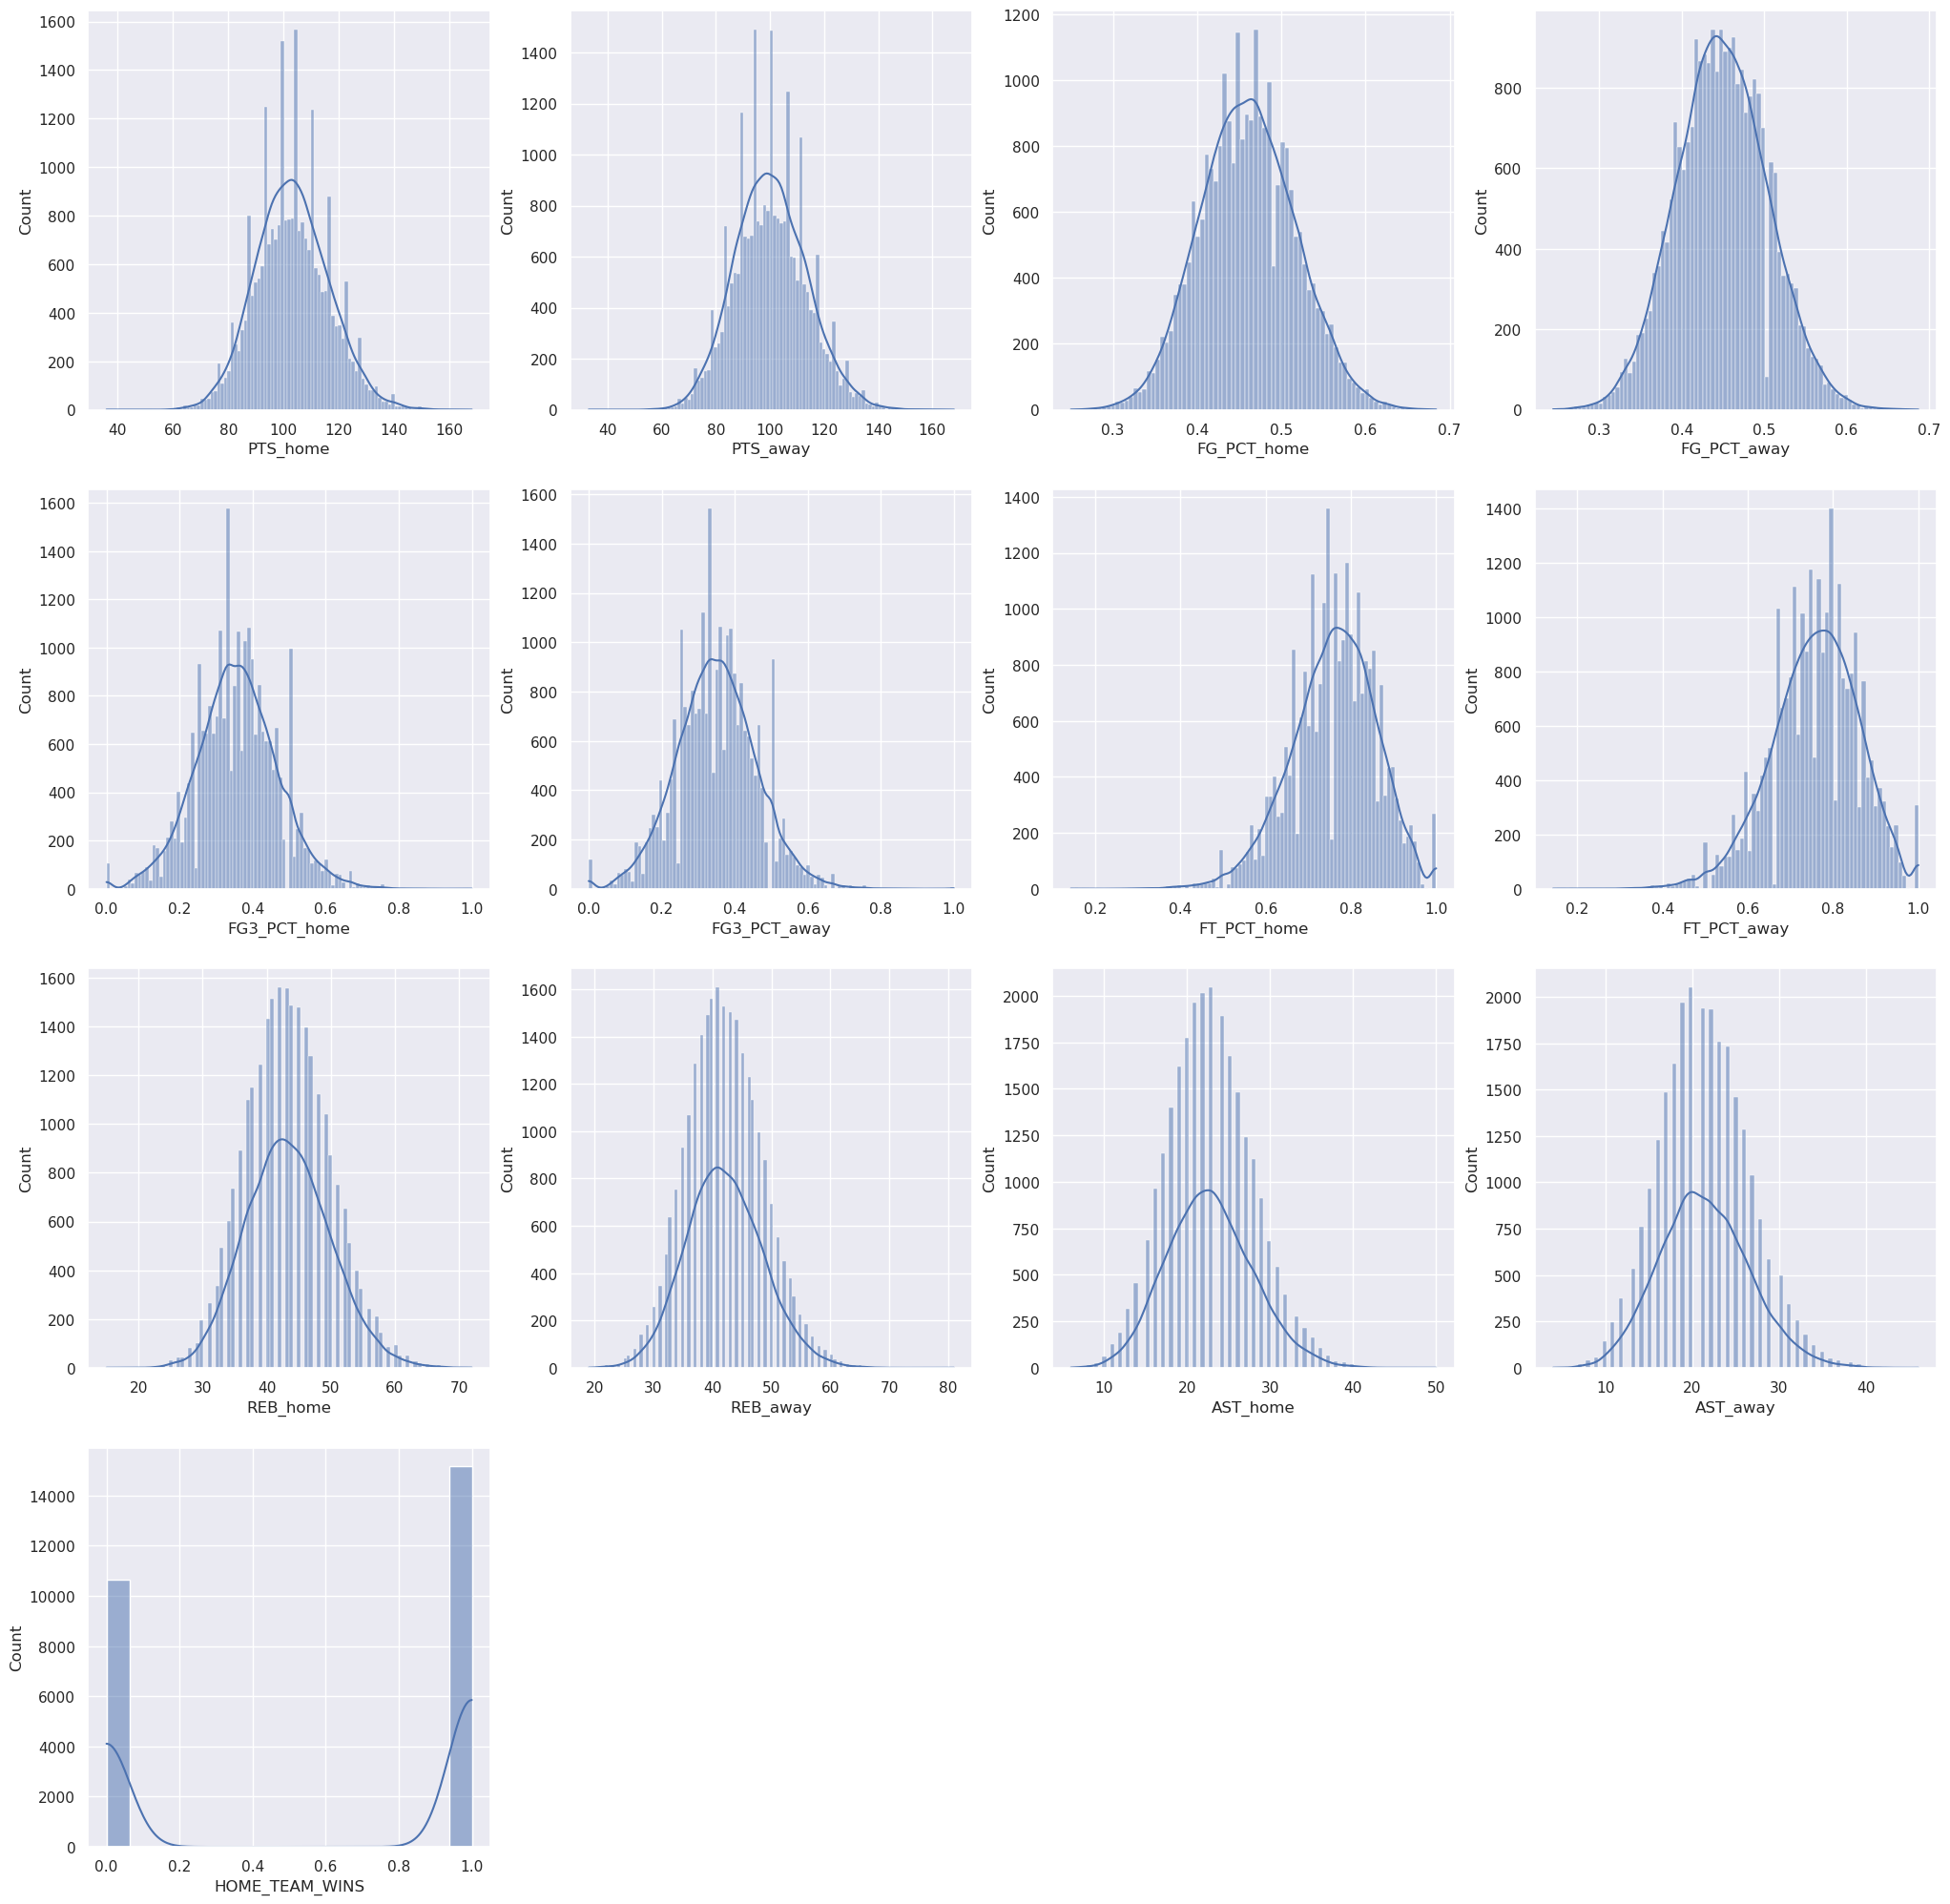

In [16]:
value_list = ['PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FG_PCT_away', 
              'FG3_PCT_home', 'FG3_PCT_away',
              'FT_PCT_home', 'FT_PCT_away', 
              'REB_home', 'REB_away',
              'AST_home', 'AST_away', 
              'HOME_TEAM_WINS',
             ]

sns.set(rc={'figure.figsize':(25,25)})
for i, column in enumerate(value_list, 1):
    plt.subplot(4,4,i)
    p=sns.histplot(x=column, data=games, stat='count', kde=True)

In [17]:
# summarize data for each season to check season by season variation

value_list = ['GAME_ID', 'HOME_TEAM_WINS', 'PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
              'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 
             ]
agg_dict = {'GAME_ID': len, 'HOME_TEAM_WINS': np.sum, 'PTS_home': np.mean, 'PTS_away': np.mean,
           'FG_PCT_home': np.mean, 'FT_PCT_home': np.mean, 'FG3_PCT_home': np.mean, 'AST_home': np.mean, 'REB_home': np.mean,
           'FG_PCT_away': np.mean, 'FT_PCT_away': np.mean, 'FG3_PCT_away': np.mean, 'AST_away': np.mean, 'REB_away': np.mean,
           }

df = pd.pivot_table(games,index=['SEASON'],
                    values=value_list,
                    aggfunc=agg_dict,
                   )
df = df.reset_index()
df = df.rename(columns={'GAME_ID': 'GAMES_PLAYED',})

df['HOME_WIN_RATIO'] = df['HOME_TEAM_WINS'] / df['GAMES_PLAYED']

# move more interesting columns to front
column1 = df.pop('GAMES_PLAYED')
column2 = df.pop('HOME_TEAM_WINS')
column3 = df.pop('HOME_WIN_RATIO')
df.insert(1,'GAMES_PLAYED', column1)
df.insert(2,'HOME_TEAM_WINS', column2)
df.insert(3,'HOME_WIN_RATIO', column3)

df

,SEASON,GAMES_PLAYED,HOME_TEAM_WINS,HOME_WIN_RATIO,AST_away,AST_home,FG3_PCT_away,FG3_PCT_home,FG_PCT_away,FG_PCT_home,FT_PCT_away,FT_PCT_home,PTS_away,PTS_home,REB_away,REB_home
0,2003,1385,800,0.577617,20.262053,22.056765,0.330227,0.342993,0.431240,0.445108,0.750990,0.748642,91.092535,94.907465,41.241058,43.173406
1,2004,1362,824,0.604993,20.240088,21.928781,0.346637,0.354970,0.441678,0.454632,0.752280,0.756231,95.381791,98.604993,41.000000,42.533040
2,2005,1432,866,0.604749,19.689944,21.152235,0.355920,0.350063,0.448051,0.460089,0.742950,0.744709,95.172486,98.406425,39.972067,41.799581
3,2006,1419,839,0.591261,20.223397,22.004933,0.348088,0.353187,0.450718,0.462074,0.748125,0.748553,96.944327,99.849190,40.442565,41.609584
4,2007,1411,862,0.610914,20.579022,22.496811,0.352690,0.359906,0.448358,0.463230,0.752360,0.757163,97.549256,101.273565,41.146704,42.702339
5,2008,1425,857,0.601404,20.002105,21.588070,0.357941,0.363791,0.451627,0.463702,0.767012,0.766348,97.903860,100.922807,40.530526,41.960000
6,2009,1424,857,0.601826,20.259831,21.884831,0.350468,0.349756,0.456085,0.465970,0.754971,0.757674,98.745787,101.654494,41.030899,42.205758
7,2010,1422,871,0.612518,20.533052,21.976090,0.348895,0.355870,0.450444,0.463857,0.759762,0.763982,97.384669,100.756681,40.860759,41.908579
8,2011,1104,656,0.594203,20.115036,21.380435,0.338460,0.344514,0.441467,0.453630,0.751953,0.753493,94.429348,97.392210,41.421196,42.860507
9,2012,1420,872,0.614085,21.218310,22.605634,0.343558,0.363454,0.445188,0.458730,0.754877,0.749131,96.114085,99.381690,41.549296,42.756338


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GAMES_PLAYED,19.0,1357.684211,109.049964,1076.000000,1370.000000,1411.000000,1421.000000,1432.000000
HOME_TEAM_WINS,19.0,797.631579,82.883593,597.000000,802.500000,819.000000,857.000000,872.000000
HOME_WIN_RATIO,19.0,0.586563,0.022238,0.536664,0.576538,0.591261,0.603287,0.614085
AST_away,19.0,21.454112,1.524009,19.689944,20.249960,21.218310,22.224126,24.302642
AST_home,19.0,22.773837,1.229183,21.152235,21.952436,22.496811,23.461422,24.961538
FG3_PCT_away,19.0,0.349273,0.007579,0.330227,0.345872,0.348895,0.354134,0.362180
FG3_PCT_home,19.0,0.355751,0.006663,0.342993,0.350853,0.355870,0.360421,0.366418
FG_PCT_away,19.0,0.449277,0.006996,0.431240,0.445298,0.450444,0.454240,0.463211
FG_PCT_home,19.0,0.460237,0.005547,0.445108,0.457373,0.462074,0.463779,0.466913
FT_PCT_away,19.0,0.758384,0.009902,0.742950,0.751471,0.754877,0.767010,0.775382


In [19]:
# summarize data for each team during 2021 to check team-by-team variation

games2021 = games[games['SEASON']==2021]

value_list = ['GAME_ID', 'HOME_TEAM_WINS', 'PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
              'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 
             ]
agg_dict = {'GAME_ID': len, 'HOME_TEAM_WINS': np.sum, 'PTS_home': np.mean, 'PTS_away': np.mean,
           'FG_PCT_home': np.mean, 'FT_PCT_home': np.mean, 'FG3_PCT_home': np.mean, 'AST_home': np.mean, 'REB_home': np.mean,
           'FG_PCT_away': np.mean, 'FT_PCT_away': np.mean, 'FG3_PCT_away': np.mean, 'AST_away': np.mean, 'REB_away': np.mean,
           }

df = pd.pivot_table(games2021,index=['HOME_TEAM_ID'],
                    values=value_list,
                    aggfunc=agg_dict,
                   )

df = df.reset_index()
df = df.rename(columns={'GAME_ID': 'GAMES_PLAYED',})

df['HOME_WIN_RATIO'] = df['HOME_TEAM_WINS'] / df['GAMES_PLAYED']

# move more interesting columns to front
column1 = df.pop('GAMES_PLAYED')
column2 = df.pop('HOME_TEAM_WINS')
column3 = df.pop('HOME_WIN_RATIO')
df.insert(1,'GAMES_PLAYED', column1)
df.insert(2,'HOME_TEAM_WINS', column2)
df.insert(3,'HOME_WIN_RATIO', column3)

df

,HOME_TEAM_ID,GAMES_PLAYED,HOME_TEAM_WINS,HOME_WIN_RATIO,AST_away,AST_home,FG3_PCT_away,FG3_PCT_home,FG_PCT_away,FG_PCT_home,FT_PCT_away,FT_PCT_home,PTS_away,PTS_home,REB_away,REB_home
0,1610612737,35,21,0.600000,25.371429,25.428571,0.364486,0.382486,0.465257,0.482886,0.791314,0.813229,110.628571,115.114286,42.257143,43.828571
1,1610612738,37,26,0.702703,21.594595,23.729730,0.344351,0.347108,0.433270,0.456270,0.785946,0.818351,103.459459,108.945946,44.540541,46.432432
2,1610612739,33,20,0.606061,23.424242,24.939394,0.321000,0.348727,0.440273,0.463364,0.760606,0.744515,100.909091,105.818182,43.727273,44.757576
3,1610612740,35,16,0.457143,23.400000,25.800000,0.357029,0.334229,0.459057,0.462800,0.780057,0.796514,109.028571,109.885714,42.285714,45.857143
4,1610612741,38,28,0.736842,24.131579,25.026316,0.351184,0.378447,0.461447,0.487342,0.774763,0.808895,108.815789,115.210526,42.921053,44.842105
5,1610612742,37,25,0.675676,23.297297,23.027027,0.323865,0.342027,0.454676,0.452595,0.745541,0.749000,102.513514,106.918919,44.432432,43.594595
6,1610612743,34,20,0.588235,24.117647,28.147059,0.347382,0.350647,0.468735,0.477029,0.751735,0.791118,109.676471,113.352941,43.382353,44.352941
7,1610612744,38,31,0.815789,22.078947,28.342105,0.327316,0.371421,0.421289,0.474553,0.775000,0.761974,102.552632,113.868421,43.342105,47.000000
8,1610612745,34,11,0.323529,24.558824,24.205882,0.349559,0.352235,0.474824,0.458500,0.773824,0.711559,117.529412,111.058824,46.205882,41.676471
9,1610612746,37,21,0.567568,24.189189,23.675676,0.326649,0.371135,0.451595,0.456865,0.789405,0.792676,108.405405,108.108108,45.945946,44.729730


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GAMES_PLAYED,30.0,35.866667,1.634400,33.000000,35.000000,36.000000,37.000000,39.000000
HOME_TEAM_WINS,30.0,19.900000,5.862505,9.000000,16.000000,20.000000,25.000000,31.000000
HOME_WIN_RATIO,30.0,0.551879,0.150059,0.272727,0.457143,0.563196,0.671230,0.815789
AST_away,30.0,23.951150,1.155892,21.594595,23.159722,24.030252,24.554253,26.027027
AST_home,30.0,24.749118,1.794987,22.055556,23.503754,24.209002,25.795946,28.342105
FG3_PCT_away,30.0,0.347572,0.012952,0.321000,0.344302,0.347391,0.355153,0.375243
FG3_PCT_home,30.0,0.351295,0.017605,0.312788,0.342584,0.352550,0.364068,0.382486
FG_PCT_away,30.0,0.454227,0.013354,0.421289,0.445919,0.458000,0.461363,0.476250
FG_PCT_home,30.0,0.461370,0.015401,0.431361,0.451463,0.462786,0.472729,0.487342
FT_PCT_away,30.0,0.773113,0.019834,0.731179,0.761774,0.774510,0.785899,0.826944
